In [1]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to the range [-1, 1]
])


In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 109530826.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 49973471.05it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 146902829.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6932506.83it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
def plot_samples():
    num_samples = 10
    noise = torch.randn(num_samples, 100, 1, 1).to(device)
    with torch.no_grad():
        fake_images = generator(noise).cpu().detach().permute(0, 2, 3, 1).numpy()

    plt.figure()
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(fake_images[i], cmap='gray')
        plt.axis('off')
        
# plot_samples()
# plt.show()

In [5]:
def init_weights(m):
    # m is the name of each layer
    # then the entire class
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Any layer other than Conv, will have weight initialization
        # A layer with conv in it will not be -1
        # the output of find method is -1 if there is no match
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class Generator(nn.Module):
    # All Conv Net is used in both generator and discriminator
    def __init__(self, ng, nc):
        super().__init__()
        self.convt1 = nn.ConvTranspose2d(latent_dim, ng*8, kernel_size=(4, 4), stride=2, padding=0)
        self.convt2 = nn.ConvTranspose2d(ng*8, ng*4, kernel_size=(4, 4), stride=2, padding=1)
        self.convt3 = nn.ConvTranspose2d(ng*4, ng*2, kernel_size=(4, 4), stride=2, padding=1)
        self.convt4 = nn.ConvTranspose2d(ng*2, ng*1, kernel_size=(4, 4), stride=2, padding=1)
        self.convt5 = nn.ConvTranspose2d(ng*1, nc, kernel_size=(4, 4), stride=2, padding=1)
        
        self.b1 = nn.BatchNorm2d(ng*8)
        self.b2 = nn.BatchNorm2d(ng*4)
        self.b3 = nn.BatchNorm2d(ng*2)
        self.b4 = nn.BatchNorm2d(ng*1)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.relu(self.b1(self.convt1(x)))
        x = self.relu(self.b2(self.convt2(x)))
        x = self.relu(self.b3(self.convt3(x)))
        x = self.relu(self.b4(self.convt4(x)))
        x = self.tanh(self.convt5(x))
        
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self, nd, nc):
        super().__init__()
        self.conv1 = nn.Conv2d(1, nd*1, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(nd*1, nd*2, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(nd*2, nd*4, 4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(nd*4, nd*8, 4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(nd*8, nc, 4, stride=2, padding=0)
        
        self.bn1 = nn.BatchNorm2d(nd*2)
        self.bn2 = nn.BatchNorm2d(nd*4)
        self.bn3 = nn.BatchNorm2d(nd*8)
        
        self.relul = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.conv1(x)
        x = self.relul(x)
        
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.relul(x)
        
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.relul(x)
        
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.relul(x)
        
        x = self.conv5(x)
        x = x.flatten(start_dim=1)
        
        x = self.sigmoid(x)
        
        return x

In [22]:
ng = 64
nd = 64
nc = 1
latent_dim = 100

criterion = nn.BCELoss()

device=torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')
generator = Generator(ng, nc).to(device)
discriminator = Discriminator(nd, nc).to(device)

generator.apply(init_weights)
discriminator.apply(init_weights)

generator_opt = optim.Adam(generator.parameters(), lr=0.0002, betas = (0.5, 0.999))
discriminator_opt = optim.Adam(discriminator.parameters(), lr=0.0002, betas = (0.5, 0.999))

In [ ]:
real_labels = torch.ones(96, 1).to(device)
fake_labels = torch.zeros(96, 1).to(device)

criterion(real_outputs, real_labels) + criterion(fake_outputs, fake_labels)

In [10]:
def reset_grad():
    generator_opt.zero_grad()
    discriminator_opt.zero_grad()

In [18]:
def train_generator(batch_size):
    real_labels = torch.ones(batch_size, 1).to(device)
    noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    fake_images = generator(noise)
    outputs = discriminator(fake_images)
    
    g_loss = criterion(outputs, real_labels)

    # Ascend the Stochastic Gradient of -log(D(G(z)+ 1e-4)) # becomes stable
    # log(1 - D(G(z)) + 1e-4)
#     g_loss = torch.mean(1-torch.log(outputs + 1e-4))
    
    g_loss.backward()
    generator_opt.step()
    
    return g_loss.item()

In [19]:
def train_discriminator(batch_size, real_images):
    real_labels = torch.ones(batch_size, 1).to(device)
    real_outputs = discriminator(real_images)
    d_loss_real = criterion(real_outputs, real_labels)

    # Ascend the Stochastic Gradient of -log(D(x)+ 1e-4) # becomes stable
#     d_loss_real = torch.mean(-torch.log(real_outputs + 1e-4))
    
    fake_labels = torch.zeros(batch_size, 1).to(device)
    noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    fake_images = generator(noise)
    fake_outputs = discriminator(fake_images)
    d_loss_fake = criterion(fake_outputs, fake_labels)

    # Minimize -log(1 - D(G(z))+ 1e-4) # becomes stable
#     d_loss_fake = torch.mean(-torch.log(1 - fake_outputs + 1e-4))
    
    d_loss = d_loss_real + d_loss_fake
    
    d_loss.backward()
    discriminator_opt.step()
    
    return d_loss

0 tensor(4.2112) tensor(0.7277)
tensor(4.2112) tensor(0.7277)


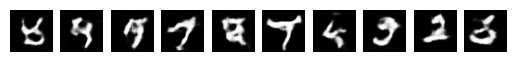

1 tensor(1.8739) tensor(0.8134)
tensor(3.0426) tensor(0.7705)


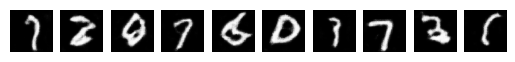

2 tensor(2.2113) tensor(0.7130)
tensor(2.7655) tensor(0.7513)


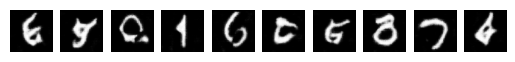

3 tensor(3.0305) tensor(0.5306)
tensor(2.8317) tensor(0.6961)


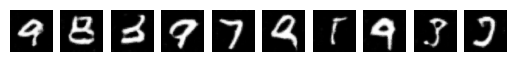

4 tensor(3.4003) tensor(0.4357)
tensor(2.9455) tensor(0.6440)


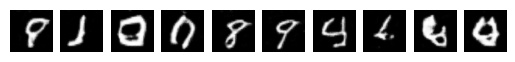

In [ ]:
epochs = 30
latent_dim = 100
batch_size = 128

d_losses, g_losses = list(), list()

for epoch in range(epochs):
    mean_d, mean_g = list(), list()
    for images, _ in train_loader:
        batch_size = images.size(0)
        real_images = images.to(device)
        
        reset_grad()
        d_loss = train_discriminator(batch_size, real_images)
        mean_d.append(d_loss)
        
        reset_grad()
        g_loss = train_generator(batch_size)
        mean_g.append(g_loss)
        
    d_losses.append(torch.mean(torch.tensor(mean_d)))
    g_losses.append(torch.mean(torch.tensor(mean_g)))
        
    if epoch % 1 == 0:
        print(epoch, torch.mean(torch.tensor(mean_g)), torch.mean(torch.tensor(mean_d)))
        print(torch.mean(torch.tensor(g_losses)), torch.mean(torch.tensor(d_losses)))
        plot_samples()
        plt.show()

In [ ]:
torch.tensor([[1, 2]])

In [ ]:
plt.imshow(gen_out[0].detach().permute(1, 2, 0).numpy())